In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cpu (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [ ]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images

    def __len__(self):
        return len(self.labels)


    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [ ]:
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)

        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)


    def forward(self,t):
        t = t

        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)


        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)


        t=self.fc2(t)
        t=F.relu(t)

        t=self.out(t)


        return t


model = Network()
dataset = Dataset()
valdataset = ValDataset()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train'

In [ ]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph
    plt.plot(epochs, losses, color='green', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=8)
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' )
    plt.ylabel('loss ------>',color='m',fontsize='xx-large')
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

In [ ]:
train(dataset,valdataset, model)

Epoch 0 total_correct 59 loss: 11.760447978973389
Epoch 1 total_correct 83 loss: 10.694782257080078
Epoch 2 total_correct 68 loss: 10.781169891357422
Epoch 3 total_correct 81 loss: 9.091343998908997
Epoch 4 total_correct 86 loss: 9.48077118396759
Epoch 5 total_correct 89 loss: 8.802300572395325
Epoch 6 total_correct 88 loss: 8.749780833721161
Epoch 7 total_correct 96 loss: 9.395366191864014
Epoch 8 total_correct 95 loss: 9.466310024261475
Epoch 9 total_correct 95 loss: 8.672347664833069
Epoch 10 total_correct 83 loss: 9.330471873283386


In [ ]:

# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("dataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [ ]:
#Save the trained model
torch.save(model.state_dict(), "model.pth")

In [ ]:
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break

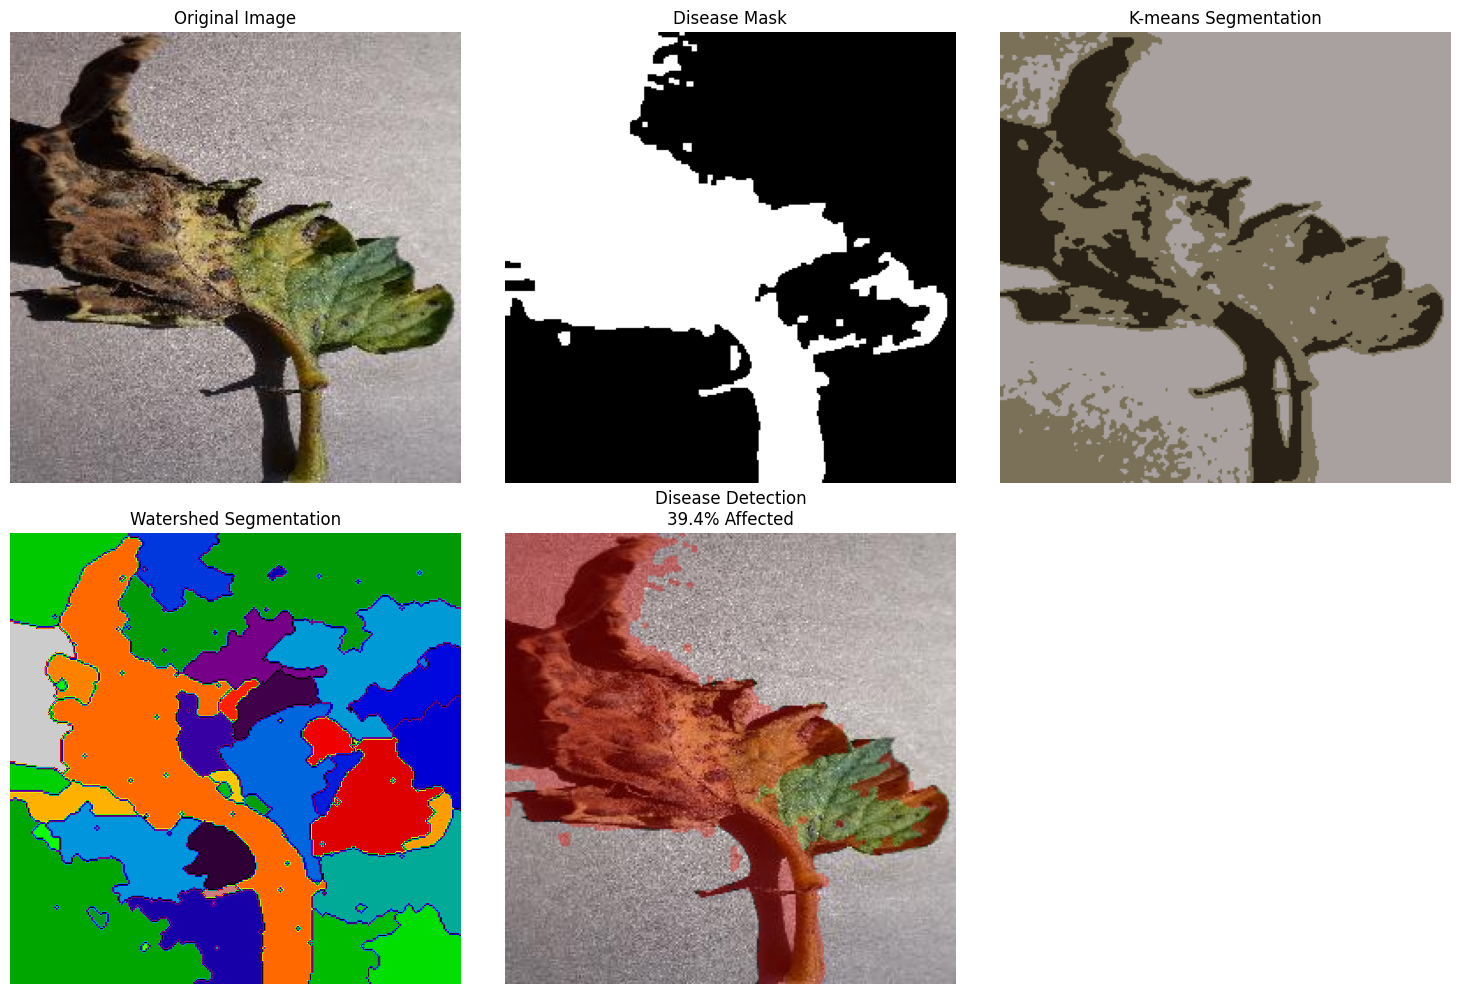

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import feature, segmentation, color

class LeafDiseaseDetector:
    """
    A class for detecting diseases in plant leaves using multiple image processing techniques.
    """

    def __init__(self):
        # Parameters for various detection methods
        self.otsu_params = {
            'gaussian_blur_kernel': (5, 5),
            'gaussian_sigma': 0
        }

        self.kmeans_params = {
            'n_clusters': 3,
            'attempts': 10
        }

        self.watershed_params = {
            'min_distance': 20,
            'footprint_size': 3
        }

    def preprocess_image(self, image):
        """
        Preprocess the image for better disease detection.

        Techniques:
        1. Gaussian Blur: Reduces noise while preserving edges
        2. Color space conversions for different analysis methods
        """
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(image,
                                 self.otsu_params['gaussian_blur_kernel'],
                                 self.otsu_params['gaussian_sigma'])

        # Convert to different color spaces
        hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
        lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2LAB)

        return blurred, hsv, lab

    def otsu_segmentation(self, lab_image):
        """
        Otsu's thresholding for initial segmentation.

        Technique:
        - Otsu's method automatically determines optimal threshold value
        - Works well for bimodal images (healthy vs diseased)
        """
        l_channel = lab_image[:,:,0]
        _, otsu_mask = cv2.threshold(l_channel, 0, 255,
                                   cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return otsu_mask

    def kmeans_segmentation(self, image, n_clusters=3):
        """
        K-means clustering for color-based segmentation.

        Technique:
        - Groups pixels into clusters based on color similarity
        - Useful for identifying different tissue conditions
        """
        pixels = image.reshape((-1, 3))
        pixels = np.float32(pixels)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, centers = cv2.kmeans(pixels, n_clusters, None, criteria,
                                      self.kmeans_params['attempts'],
                                      cv2.KMEANS_RANDOM_CENTERS)

        # Convert back to uint8 and reshape
        centers = np.uint8(centers)
        segmented_image = centers[labels.flatten()]
        segmented_image = segmented_image.reshape(image.shape)

        return segmented_image, labels.reshape(image.shape[:2])


    def watershed_segmentation(self, image, markers):
        """
        Watershed segmentation for region separation.

        Technique:
        - Uses gradient information to separate regions
        - Good for detecting boundaries between healthy and diseased areas
        """
        gradient = ndimage.gaussian_gradient_magnitude(color.rgb2gray(image), 2)

        # Create a marker image with the same shape as the original image
        markers_image = np.zeros_like(color.rgb2gray(image), dtype=np.int32)

        # Set marker values at the coordinates obtained from peak_local_max
        for i, (row, col) in enumerate(markers):
            markers_image[row, col] = i + 1  # Assign unique labels to each marker

        # Use the markers_image instead of markers in the watershed function
        segmentation_mask = segmentation.watershed(gradient, markers_image,
                                                 watershed_line=True)
        return segmentation_mask

    def detect_disease(self, image_path):
        """
        Main method combining multiple techniques for disease detection.

        Process:
        1. Preprocessing
        2. Multiple segmentation techniques
        3. Combination of results
        4. Post-processing
        """
        # Read and convert image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Preprocess
        blurred, hsv, lab = self.preprocess_image(img_rgb)

        # 1. Otsu's thresholding
        otsu_mask = self.otsu_segmentation(lab)

        # 2. K-means clustering
        kmeans_result, kmeans_labels = self.kmeans_segmentation(blurred)

        # 3. Color-based detection in HSV space
        lower_disease = np.array([0, 20, 20])
        upper_disease = np.array([30, 255, 200])
        hsv_mask = cv2.inRange(hsv, lower_disease, upper_disease)

        # 4. Watershed segmentation
        markers = feature.peak_local_max(color.rgb2gray(img_rgb),
                                       min_distance=self.watershed_params['min_distance'],
                                       footprint=np.ones((self.watershed_params['footprint_size'],
                                                        self.watershed_params['footprint_size'])),
                                       labels=kmeans_labels)
        watershed_mask = self.watershed_segmentation(img_rgb, markers)

        # Combine results
        combined_mask = cv2.bitwise_or(otsu_mask, hsv_mask)
        combined_mask = cv2.bitwise_and(combined_mask,
                                      (watershed_mask > 0).astype(np.uint8) * 255)

        # Post-processing
        kernel = np.ones((3,3), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
        combined_mask = ndimage.binary_fill_holes(combined_mask).astype(np.uint8) * 255

        # Create visualization
        overlay = img_rgb.copy()
        overlay[combined_mask > 0] = [255, 0, 0]  # Red for diseased areas
        segmented = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)

        # Calculate disease severity
        total_pixels = np.sum(img_rgb[:,:,0] > 0)
        diseased_pixels = np.sum(combined_mask > 0)
        disease_percentage = (diseased_pixels / total_pixels) * 100 if total_pixels > 0 else 0

        return {
            'original': img_rgb,
            'mask': combined_mask,
            'segmented': segmented,
            'disease_percentage': disease_percentage,
            'kmeans_result': kmeans_result,
            'watershed_result': watershed_mask
        }

def visualize_all_results(results):
    """
    Visualize results from all techniques.
    """
    plt.figure(figsize=(15, 10))

    # Original
    plt.subplot(231)
    plt.imshow(results['original'])
    plt.title('Original Image')
    plt.axis('off')

    # Disease Mask
    plt.subplot(232)
    plt.imshow(results['mask'], cmap='gray')
    plt.title('Disease Mask')
    plt.axis('off')

    # K-means
    plt.subplot(233)
    plt.imshow(results['kmeans_result'])
    plt.title('K-means Segmentation')
    plt.axis('off')

    # Watershed
    plt.subplot(234)
    plt.imshow(results['watershed_result'], cmap='nipy_spectral')
    plt.title('Watershed Segmentation')
    plt.axis('off')

    # Final Result
    plt.subplot(235)
    plt.imshow(results['segmented'])
    plt.title(f'Disease Detection\n{results["disease_percentage"]:.1f}% Affected')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    detector = LeafDiseaseDetector()
    results = detector.detect_disease("/content/TomatoEarlyBlight1.JPG")
    visualize_all_results(results)

In [ ]:
def predict():
    # Path to your test data directory
    test_data_dir = "dataset/test"

    # Get a list of all image files in the test data directory
    image_files = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]

    # Randomly select an image file
    random_image_file = random.choice(image_files)

    # Construct the full path to the random image
    random_image_path = os.path.join(test_data_dir, random_image_file)

    # Now, proceed with prediction using the random image path
    image = Image.open(random_image_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256, 256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)

    for key, value in reference.items():
        if value == result_idx:
            print(key)
            break
    image = transforms.ToPILImage()(image)
    display(image)

Tomato___Target_Spot


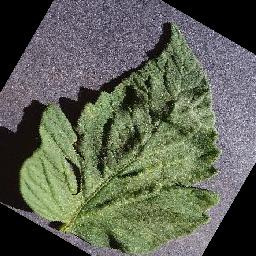

In [ ]:
predict()